## Data cleaning

### Set up

We first import the different libraries that we will be using for this project

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime 

We import our dataset

In [ ]:
data_path="data/fires-time-series.xlsx"
try:
    df=pd.read_excel(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")
df.head()

### Group by weeks

Agrupamos los datos y obtenemos el número total de incendios y la superficie quemada por semana.

In [ ]:
# Asegurarse de que la columna 'fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Agregar columna de semana (Año-Semana)
df['semana'] = df['fecha'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana
df = df.groupby('semana').agg(
    numero_incendios=('superficie', 'count'),  # Cuenta las filas
    superficie_total=('superficie', 'sum')    # Suma la superficie
).reset_index()

# Crear rango completo de semanas desde el primer lunes de 1983 hasta la última fecha
start_date = pd.Timestamp("1983-01-01")
end_date = df['semana'].max()

# Generar rango de semanas completas
full_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Crear un DataFrame con las semanas completas
weeks_df = pd.DataFrame({'semana': full_weeks})

# Combinar con el DataFrame original (left join)
df = weeks_df.merge(df, on='semana', how='left')

# Rellenar valores NaN con 0 para las columnas numéricas
df['numero_incendios'] = df['numero_incendios'].fillna(0).astype(int)
df['superficie_total'] = df['superficie_total'].fillna(0)

# Agregar columnas de año y número de semana
df['año'] = df['semana'].dt.year
df['semana_año'] = df['semana'].dt.isocalendar().week

df.head()

### Split train and test data

Los datos para entrenamiento son el 80% inicial (1983-2011) y los de test el 20% restante (2012-2018).

In [ ]:
# Dividir los datos en train y test
df_train = df[df['año'] <= 2011].reset_index(drop=True) #Modificados
df_test = df[df['año'] >= 2012].reset_index(drop=True)

# Calcular tamaños de train y test
train_size = len(df_train)
test_size = len(df_test)
total_size = len(df)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train.head(), "\n--------------\n", df_train.tail())
print("\nTest:")
print(df_test.head(), "\n--------------\n", df_test.tail()) # No se usará hasta el final

## Train models

### Analyze train data set

In [ ]:
#TODO (Quitar seguramente o hacer manualmente con Data Wrangler)

### Time series

Tendremos que hacer 3 modelos con series temporales:
- Predecir numero de incendios
- Predecir hectareas quemadas
- Predecir ambas cosas a la vez

Después introducir también variables exógenas (meteorológicas).

Definimos una función que nos permita transformar el dataframe haciendo 'windowing', indicando el número de semanas de la ventana, las variables predictoras y las variables exógenas.

In [ ]:
def create_windowed_dataframe(df, n_weeks, target_vars, exogenous_vars):
    """
    Crea un DataFrame con windowing para múltiples variables objetivo y exógenas,
    conservando la columna de semanas.
    
    Args:
        df (DataFrame): DataFrame con las columnas relevantes.
        n_weeks (int): Número de semanas previas a incluir.
        target_vars (list): Variables objetivo (a predecir).
        exogenous_vars (list): Variables exógenas.
        week_col (str): Nombre de la columna que contiene las semanas.
    
    Returns:
        df_windowed (DataFrame): DataFrame con las variables de entrada, salida y columna de semanas.
    """
    data = df.copy()
    features = target_vars + exogenous_vars
    columns = ["semana"]  # Mantener la columna semana

    # Crear nombres de columnas para las semanas previas
    for week in range(-n_weeks, 0):
        columns.extend([f"{col}_week_{week}" for col in features])
    
    # Agregar columnas para las variables objetivo actuales
    columns.extend(target_vars)

    rows = []

    for i in range(n_weeks, len(data)):
        # Semana actual
        current_week = data["semana"].iloc[i]

        # Inputs: Variables de las últimas n semanas
        input_window = data[features].iloc[i-n_weeks:i].values.flatten().tolist()

        # Outputs: Variables objetivo para la semana actual
        output_window = data[target_vars].iloc[i].values.tolist()

        # Combinar inputs, outputs y la semana actual
        rows.append([current_week] + input_window + output_window)
    
    # Crear DataFrame final
    df_windowed = pd.DataFrame(rows, columns=columns)
    return df_windowed


#### Modelo 1: Número de incendios
Para el primer caso, utilizamos solo el número de incendios sin variables exógenas.

In [ ]:
target_vars = ["numero_incendios"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 10  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

Vamos a probar a utilizar Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-1]
y_train = df_windowed_train.iloc[:, -1]
X_test = df_windowed_test.iloc[:, 1:-1]
y_test = df_windowed_test.iloc[:, -1]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score : 42.491501455380345
MAE en conjunto de test final: 11.7675
Predicciones en conjunto de test: [  8.22986905   4.65332137  17.53606857   5.01383805  30.3471423
  31.90333615  49.74902239  48.30953851 112.42681427 114.14172925
 107.47596525 101.69920308  82.11744286 223.85790293  60.31535667
   6.93441504   2.01864903   1.64215923   2.4923554   17.16848648
   9.87671322  19.35986295  17.63957056   4.04214671   5.26325569
   8.78480146  15.35904243   7.51237538   3.63026119  15.97790429
  17.83555891  27.74429669  38.57340737  17.4351395   25.34965558
  30.65612945  38.21255855  48.72314076  63.41600629  15.2735648
  21.15627726   5.68112578   4.17864103   1.89243511   4.21591917
   1.42908254   1.98148629   1.82504634   3.72185034   2.26511499
   2.68794854   2.81713579   3.24487168   3.09708402   2.81091232


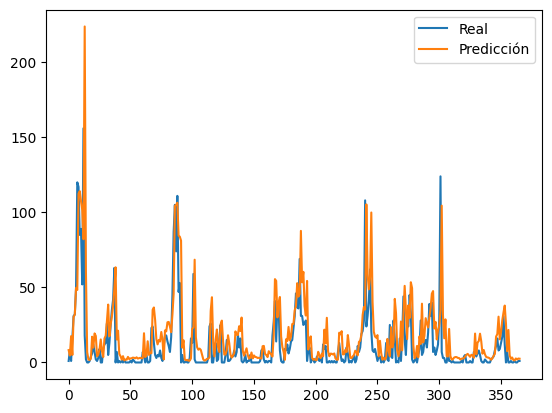

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el parámetro de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo de muestras en una hoja
}

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score : {-grid_search.best_score_}")

# Mejor modelo después de la búsqueda
best_rf_1 = grid_search.best_estimator_

# Predecir en el conjunto de test
y_pred_test = best_rf_1.predict(X_test)

# Evaluar en el conjunto de test final
final_mae = mean_absolute_error(y_test, y_pred_test)

# Resultados
print(f"MAE en conjunto de test final: {final_mae:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicción")
plt.legend()
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

In [ ]:
# # Reshape para que tenga formato [n_samples, timesteps, n_features]
# X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)  # n_features = 1, ya que solo tenemos una característica

# # Imprimir las formas de X y y
# print("Forma de X:", X_train_lstm.shape)  # (n_samples, timesteps, n_features)
# print("Forma de y:", y_train.shape)      # (n_samples, )

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Error promedio de validación cruzada: 39.84118390229941
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8816  
Pérdida en prueba: 9.491365432739258
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


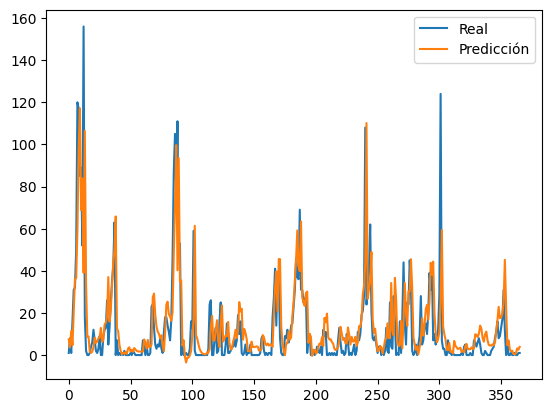

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    errors.append(mean_absolute_error(y_val_fold, y_val_pred))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(errors))

# Evaluar
loss = model.evaluate(X_test_lstm, y_test.values)
print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)


plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.show()


## Performances

In [ ]:
#TODO

## Test Model


In [ ]:
#TODO